In [4]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума

## 1. Импорты

In [5]:
import cv2 as cv
import numpy as np
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
%matplotlib inline


img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)

## 2. Реализация высокочастотной фильтрации на основе ядра Гаусса

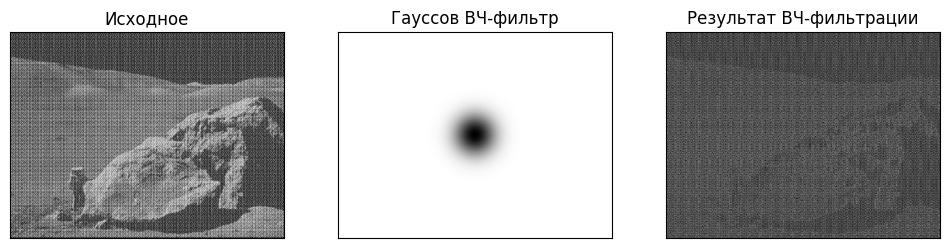

In [6]:
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

D0 = 40

u = np.arange(rows) - crow
v = np.arange(cols) - ccol
V, U = np.meshgrid(v, u)
D2 = U**2 + V**2

H_low = np.exp(-D2 / (2 * (D0**2)))
H_high = 1 - H_low

gauss_hp = np.zeros((rows, cols, 2), np.float32)
gauss_hp[:, :, 0] = H_high
gauss_hp[:, :, 1] = H_high

dft_gauss_hp = dft_shift * gauss_hp

mag_gauss_hp = 20 * np.log(cv.magnitude(dft_gauss_hp[:, :, 0],
                                        dft_gauss_hp[:, :, 1]) + 1)
f_ishift = np.fft.ifftshift(dft_gauss_hp)
img_gauss_hp = cv.idft(f_ishift)
img_gauss_hp = cv.magnitude(img_gauss_hp[:, :, 0], img_gauss_hp[:, :, 1])

plt.figure(figsize=(12, 4))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Исходное'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(H_high, cmap='gray')
plt.title('Гауссов ВЧ-фильтр'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_gauss_hp, cmap='gray')
plt.title('Результат ВЧ-фильтрации'), plt.xticks([]), plt.yticks([])
plt.show()

## 3. Удаление периодического шума

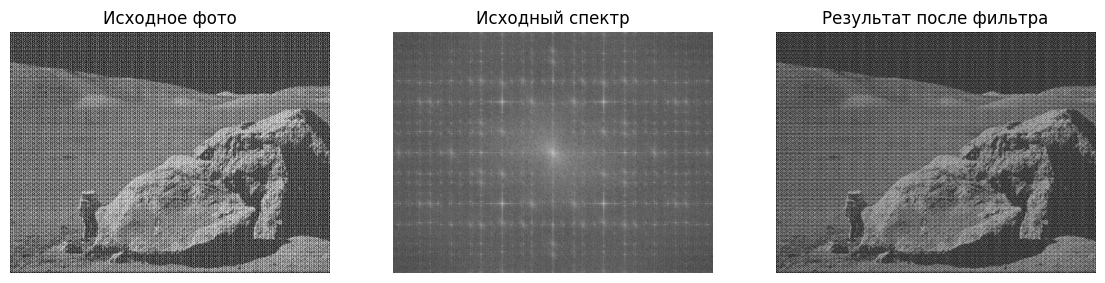

In [7]:
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
Y, X = np.ogrid[:rows, :cols]

mag = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1)

r0 = 20
center_mask = (Y - crow)**2 + (X - ccol)**2 <= r0**2
mag_wo_center = mag.copy()
mag_wo_center[center_mask] = 0

num_peaks = 2
peaks_idx = np.argpartition(mag_wo_center.flatten(), -num_peaks)[-num_peaks:]
peaks = np.column_stack(np.unravel_index(peaks_idx, mag_wo_center.shape))

r = 12
mask_notch = np.ones((rows, cols, 2), np.float32)

for (y, x) in peaks:
    y_sym = 2 * crow - y
    x_sym = 2 * ccol - x

    notch = (Y - y)**2 + (X - x)**2 <= r**2
    notch_sym = (Y - y_sym)**2 + (X - x_sym)**2 <= r**2

    mask_notch[:,:,0][notch | notch_sym] = 0
    mask_notch[:,:,1][notch | notch_sym] = 0

dft_notch = dft_shift * mask_notch

mag_notch = 20 * np.log(cv.magnitude(dft_notch[:,:,0], dft_notch[:,:,1]) + 1)

f_ishift = np.fft.ifftshift(dft_notch)
img_notch = cv.idft(f_ishift)
img_notch = cv.magnitude(img_notch[:,:,0], img_notch[:,:,1])

plt.figure(figsize=(14,4))
plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Исходное фото'), plt.axis('off')
plt.subplot(132), plt.imshow(mag, cmap='gray'), plt.title('Исходный спектр'), plt.axis('off')
plt.subplot(133), plt.imshow(img_notch, cmap='gray'), plt.title('Результат после фильтра'), plt.axis('off')
plt.show()

### 5. Спектр до и после фильтрации

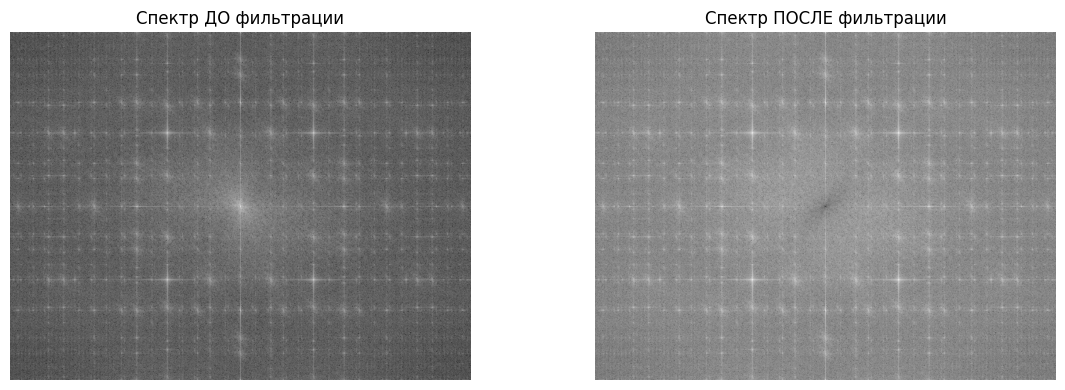

In [8]:
if "dft_shift" not in globals():
    if "dft" in globals():
        dft_shift = np.fft.fftshift(dft)
    else:
        dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

mag_before = 20 * np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]) + 1)
mag_after = 20 * np.log(cv.magnitude(dft_gauss_hp[:, :, 0], dft_gauss_hp[:, :, 1]) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(mag_before, cmap="gray"), plt.title("Спектр ДО фильтрации"), plt.axis("off")
plt.subplot(122), plt.imshow(mag_after, cmap="gray"), plt.title("Спектр ПОСЛЕ фильтрации"), plt.axis("off")
plt.tight_layout()
plt.show()
